In [1]:
!kaggle datasets download -d trainingdatapro/computed-tomography-ct-of-the-brain

 99%|█████████████████████████████████████▍| 65.0M/66.0M [00:05<00:00, 18.2MB/s]
100%|██████████████████████████████████████| 66.0M/66.0M [00:05<00:00, 12.4MB/s]


In [2]:
!unzip computed-tomography-ct-of-the-brain.zip -d data_input

Archive:  computed-tomography-ct-of-the-brain.zip
  inflating: data_input/ct_brain.csv  
  inflating: data_input/files/aneurysm/0.dcm  
  inflating: data_input/files/aneurysm/0.jpg  
  inflating: data_input/files/aneurysm/1.dcm  
  inflating: data_input/files/aneurysm/1.jpg  
  inflating: data_input/files/aneurysm/10.dcm  
  inflating: data_input/files/aneurysm/10.jpg  
  inflating: data_input/files/aneurysm/11.dcm  
  inflating: data_input/files/aneurysm/11.jpg  
  inflating: data_input/files/aneurysm/12.dcm  
  inflating: data_input/files/aneurysm/12.jpg  
  inflating: data_input/files/aneurysm/13.dcm  
  inflating: data_input/files/aneurysm/13.jpg  
  inflating: data_input/files/aneurysm/14.dcm  
  inflating: data_input/files/aneurysm/14.jpg  
  inflating: data_input/files/aneurysm/15.dcm  
  inflating: data_input/files/aneurysm/15.jpg  
  inflating: data_input/files/aneurysm/16.dcm  
  inflating: data_input/files/aneurysm/16.jpg  
  inflating: data_input/files/aneurysm/17.dcm  
  i

In [12]:
# import library 

import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.image as mpimg
import tensorflow as tf
import pydicom as discom

2023-11-06 09:43:38.754724: I tensorflow/core/util/port.cc:110] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2023-11-06 09:43:38.771947: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2023-11-06 09:43:38.878849: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2023-11-06 09:43:38.879691: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F AVX512_VNNI AVX512_BF16 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-11-06 09:43:39.531870: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT

In [88]:
df = pd.read_csv('data_input/ct_brain.csv')
df.head()

,dcm,jpg,type
0,/aneurysm/0.dcm,/aneurysm/0.jpg,aneurysm
1,/aneurysm/1.dcm,/aneurysm/1.jpg,aneurysm
2,/aneurysm/2.dcm,/aneurysm/2.jpg,aneurysm
3,/aneurysm/3.dcm,/aneurysm/3.jpg,aneurysm
4,/aneurysm/4.dcm,/aneurysm/4.jpg,aneurysm


In [89]:
# coumt the type

df['type'].value_counts()


type
cancer      90
aneurysm    83
tumor       83
Name: count, dtype: int64

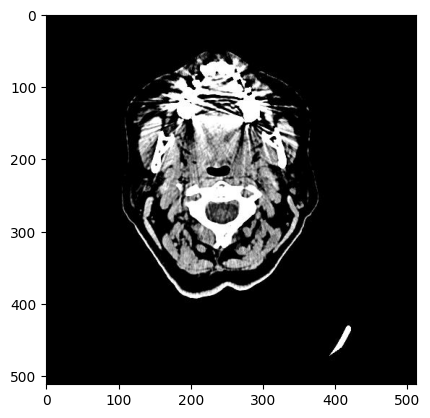

In [9]:
image = mpimg.imread('data_input/files/aneurysm/0.jpg')
plt.imshow(image)

In [10]:
image.shape

(512, 512, 3)

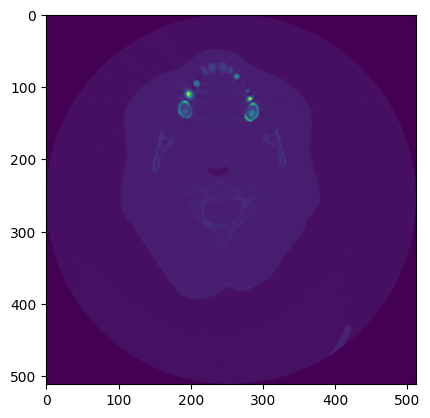

In [13]:
ds = discom.dcmread('data_input/files/aneurysm/0.dcm')
plt.imshow(ds.pixel_array)

In [14]:
# load data

ds = tf.data.Dataset.list_files('data_input/files/*/*.jpg', shuffle=False)


2023-11-06 09:49:35.526386: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:995] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2023-11-06 09:49:35.526861: W tensorflow/core/common_runtime/gpu/gpu_device.cc:1960] Cannot dlopen some GPU libraries. Please make sure the missing libraries mentioned above are installed properly if you would like to use GPU. Follow the guide at https://www.tensorflow.org/install/gpu for how to download and setup the required libraries for your platform.
Skipping registering GPU devices...


In [16]:
import torch 

if torch.cuda.is_available():
    device = torch.device('cuda')
else:  
    device = torch.device('cpu')

device

device(type='cuda')

In [90]:
IMAGE_SIZE = 516
BATCH_SIZE = 32
CHANNELS = 3
dataset = tf.keras.preprocessing.image_dataset_from_directory(
    'data_input/files',
    image_size = (IMAGE_SIZE, IMAGE_SIZE),
    batch_size = BATCH_SIZE,
    shuffle = True,
    # seed = 42,
    # validation_split = 0.2,
    # subset = 'training'
)



Found 259 files belonging to 3 classes.


In [91]:
class_ = dataset.class_names
class_

['aneurysm', 'cancer', 'tumor']

(516, 516, 3)


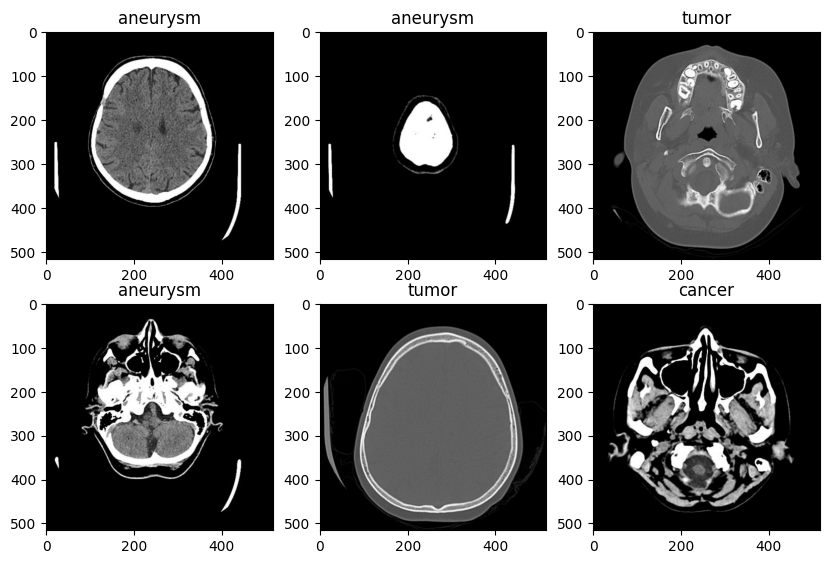

In [92]:
for img, label in dataset.take(1):
    print(img[0].shape)
    plt.figure(figsize=(10,10))
    for i in range(6):
        plt.subplot(3,3,i+1)
        plt.title(class_[label[i]])
        plt.imshow(img[i].numpy().astype('uint8'))
        

In [93]:
# train test validation split

def split_train_test_val(ds, train_split = 0.8, test_split= 0.1, val_split=0.1, shuffle=False):
    ds_size = len(ds)
    train_size = round(train_split * ds_size)
    test_size = round(test_split * ds_size)
    val_size = round(val_split * ds_size)

    if shuffle:
        ds = ds.shuffle()

    train_ds = ds.take(train_size)
    test_ds = ds.skip(train_size).take(test_size)
    val_ds = ds.skip(train_size + test_size)
    return train_ds, test_ds, val_ds


In [94]:
train_ds,test_ds, val_ds = split_train_test_val(ds=dataset)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


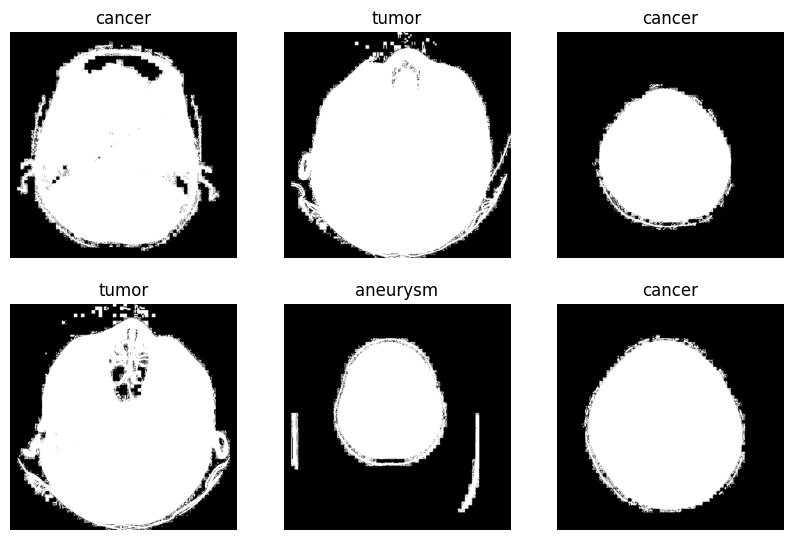

In [95]:
for batch, label in train_ds.take(1):
    plt.figure(figsize=(10,10))
    for idx in range(6):
        plt.subplot(3,3,idx+1) 
        plt.imshow(batch[idx].numpy())
        plt.title(class_[label[idx].numpy()])
        plt.axis('off')

In [96]:
# cache and prefetch

train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
test_ds = test_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
val_ds = val_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)

In [97]:
from tensorflow.keras import models, layers

image_preprocessing = tf.keras.Sequential([
    tf.keras.layers.Resizing(IMAGE_SIZE, IMAGE_SIZE,
                             interpolation='bilinear',
                             crop_to_aspect_ratio=False),
    tf.keras.layers.Rescaling(1./255)
])
    

In [98]:
# model

input_size = (BATCH_SIZE, IMAGE_SIZE, IMAGE_SIZE, CHANNELS)
model = models.Sequential([
    image_preprocessing,
    layers.Conv2D(32, 3, activation='relu', input_shape=input_size),
    layers.MaxPooling2D(),
    layers.Conv2D(32, 3, activation='relu'),
    layers.MaxPooling2D(),
    layers.Conv2D(32, 3, activation='relu'),
    layers.MaxPooling2D(),
    layers.Dropout(0.7),
    layers.Flatten(),
    # layers.Dense(128, activation='relu'),
    layers.Dense(len(class_), activation='softmax')
])

model.build(input_size)


In [99]:
model.summary()

Model: "sequential_13"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential_12 (Sequential)  (32, 516, 516, 3)         0         
                                                                 
 conv2d_27 (Conv2D)          (32, 514, 514, 32)        896       
                                                                 
 max_pooling2d_25 (MaxPooli  (32, 257, 257, 32)        0         
 ng2D)                                                           
                                                                 
 conv2d_28 (Conv2D)          (32, 255, 255, 32)        9248      
                                                                 
 max_pooling2d_26 (MaxPooli  (32, 127, 127, 32)        0         
 ng2D)                                                           
                                                                 
 conv2d_29 (Conv2D)          (32, 125, 125, 32)      

In [100]:
# compile model

model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
              metrics = ['accuracy'])


In [101]:
epochs = 10
history = model.fit(train_ds, epochs=epochs, validation_data=val_ds)

Epoch 1/10
7/7 [==============================] - 6s 735ms/step - loss: 0.7690 - accuracy: 0.7009 - val_loss: 0.1324 - val_accuracy: 1.0000
Epoch 2/10
7/7 [==============================] - 5s 706ms/step - loss: 0.2838 - accuracy: 0.9420 - val_loss: 0.0729 - val_accuracy: 1.0000
Epoch 3/10
7/7 [==============================] - 5s 706ms/step - loss: 0.1226 - accuracy: 0.9777 - val_loss: 0.1127 - val_accuracy: 1.0000
Epoch 4/10
7/7 [==============================] - 5s 701ms/step - loss: 0.0625 - accuracy: 0.9866 - val_loss: 0.0079 - val_accuracy: 1.0000
Epoch 5/10
7/7 [==============================] - 5s 696ms/step - loss: 0.0973 - accuracy: 0.9732 - val_loss: 0.2658 - val_accuracy: 0.6667
Epoch 6/10
7/7 [==============================] - 5s 712ms/step - loss: 0.0636 - accuracy: 0.9688 - val_loss: 0.0378 - val_accuracy: 1.0000
Epoch 7/10
7/7 [==============================] - 5s 714ms/step - loss: 0.0693 - accuracy: 0.9866 - val_loss: 0.0070 - val_accuracy: 1.0000
Epoch 8/10
7/7 [====

In [102]:
# plot by the graph

def plot_graphs(history, string):
    plt.plot(history.history[string])
    plt.plot(history.history['val_'+string])
    plt.xlabel('epochs')
    plt.ylabel(string)
    plt.legend([string, 'val_'+string])
    plt.show()
    

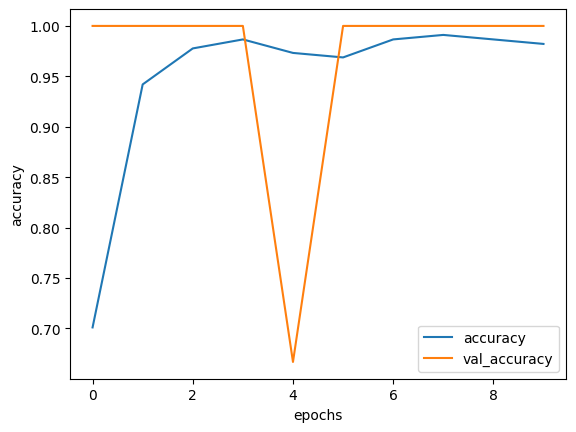

In [103]:
plot_graphs(history, 'accuracy')

In [104]:
# model number two

input_size = (BATCH_SIZE,IMAGE_SIZE,IMAGE_SIZE,CHANNELS)
model_2 = models.Sequential([
    image_preprocessing,
    layers.Conv2D(32,(8,8),activation='relu',input_shape=input_size),
    layers.MaxPooling2D(pool_size=(2, 2),strides=(2, 2), padding='valid'),
    layers.Conv2D(64,kernel_size=(4,4),activation='relu'),
    layers.Dropout(.2),
    layers.Conv2D(64,kernel_size=(3,3),activation='relu'),
    layers.Flatten(),
    layers.Dense(len(class_),activation='softmax')
])

model_2.build(input_shape=input_size)


In [105]:
model_2.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
              metrics = ['accuracy'])


In [106]:
epochs = 10
history = model_2.fit(train_ds, epochs=epochs, validation_data=val_ds)

Epoch 1/10
7/7 [==============================] - 14s 2s/step - loss: 11.0189 - accuracy: 0.6071 - val_loss: 0.0228 - val_accuracy: 1.0000
Epoch 2/10
7/7 [==============================] - 13s 2s/step - loss: 0.2782 - accuracy: 0.9152 - val_loss: 0.3624 - val_accuracy: 0.6667
Epoch 3/10
7/7 [==============================] - 13s 2s/step - loss: 0.1050 - accuracy: 0.9554 - val_loss: 0.0233 - val_accuracy: 1.0000
Epoch 4/10
7/7 [==============================] - 13s 2s/step - loss: 0.6889 - accuracy: 0.9598 - val_loss: 0.7951 - val_accuracy: 0.6667
Epoch 5/10
7/7 [==============================] - 13s 2s/step - loss: 0.2211 - accuracy: 0.9688 - val_loss: 0.0019 - val_accuracy: 1.0000
Epoch 6/10
7/7 [==============================] - 13s 2s/step - loss: 0.1147 - accuracy: 0.9777 - val_loss: 0.0312 - val_accuracy: 1.0000
Epoch 7/10
7/7 [==============================] - 14s 2s/step - loss: 0.0438 - accuracy: 0.9911 - val_loss: 0.0153 - val_accuracy: 1.0000
Epoch 8/10
7/7 [=================

In [107]:
# plot by the graph

def plot_graphs(history, string):
    plt.plot(history.history[string])
    plt.plot(history.history['val_'+string])
    plt.xlabel('epochs')
    plt.ylabel(string)
    plt.legend([string, 'val_'+string])
    plt.show()
    

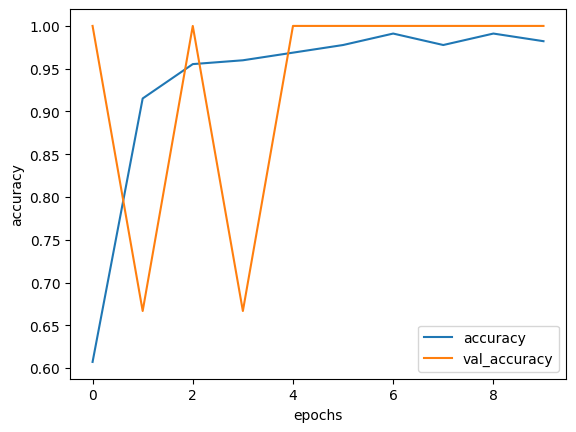

In [108]:
plot_graphs(history, 'accuracy')

In [109]:
score = model.evaluate(test_ds)

1/1 [==============================] - 0s 360ms/step - loss: 0.0572 - accuracy: 0.9688


In [110]:
score_2 = model_2.evaluate(test_ds)

1/1 [==============================] - 0s 482ms/step - loss: 0.0652 - accuracy: 0.9688


1/1 [==============================] - 0s 243ms/step


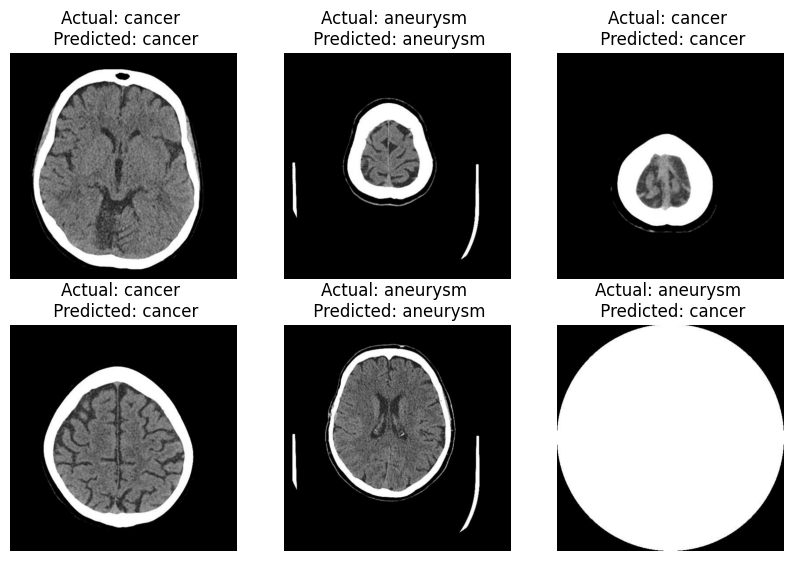

In [111]:
# prediction

for img, label in test_ds.take(1):
    plt.figure(figsize=(10,10))
    for i in range(6):
        plt.subplot(3,3,i+1)
        pred = model.predict(img.numpy())
        plt.title(f'Actual: {class_[label[i]]} \n Predicted: {class_[np.argmax(pred[i])]}')
        plt.imshow(img[i].numpy().astype('uint8'))
        plt.axis('off')
        

1/1 [==============================] - 0s 465ms/step


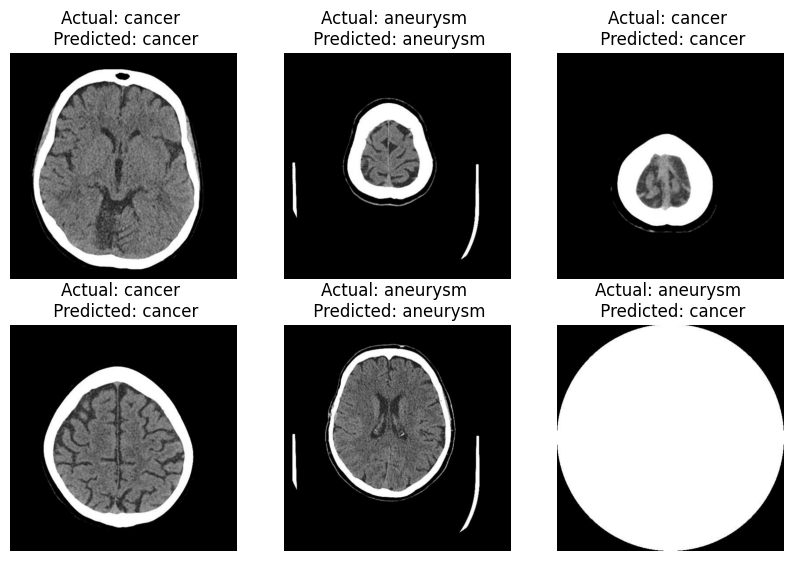

In [112]:
# prediction

for img, label in test_ds.take(1):
    plt.figure(figsize=(10,10))
    for i in range(6):
        plt.subplot(3,3,i+1)
        pred = model_2.predict(img.numpy())
        plt.title(f'Actual: {class_[label[i]]} \n Predicted: {class_[np.argmax(pred[i])]}')
        plt.imshow(img[i].numpy().astype('uint8'))
        plt.axis('off')
        

In [113]:
# find the classifcation report

from sklearn.metrics import classification_report

y_pred = []
y_true = []
for img, label in test_ds.take(1):
    for i in range(len(img)):
        pred = model_2.predict(img.numpy())
        y_pred.append(np.argmax(pred[i]))
        y_true.append(label[i].numpy())

print(classification_report(y_true, y_pred, target_names=class_))

1/1 [==============================] - 0s 483ms/step
              precision    recall  f1-score   support

    aneurysm       1.00      0.91      0.95        11
      cancer       0.92      1.00      0.96        12
       tumor       1.00      1.00      1.00         9

    accuracy                           0.97        32
   macro avg       0.97      0.97      0.97        32
weighted avg       0.97      0.97      0.97        32



1/1 [==============================] - 0s 468ms/step


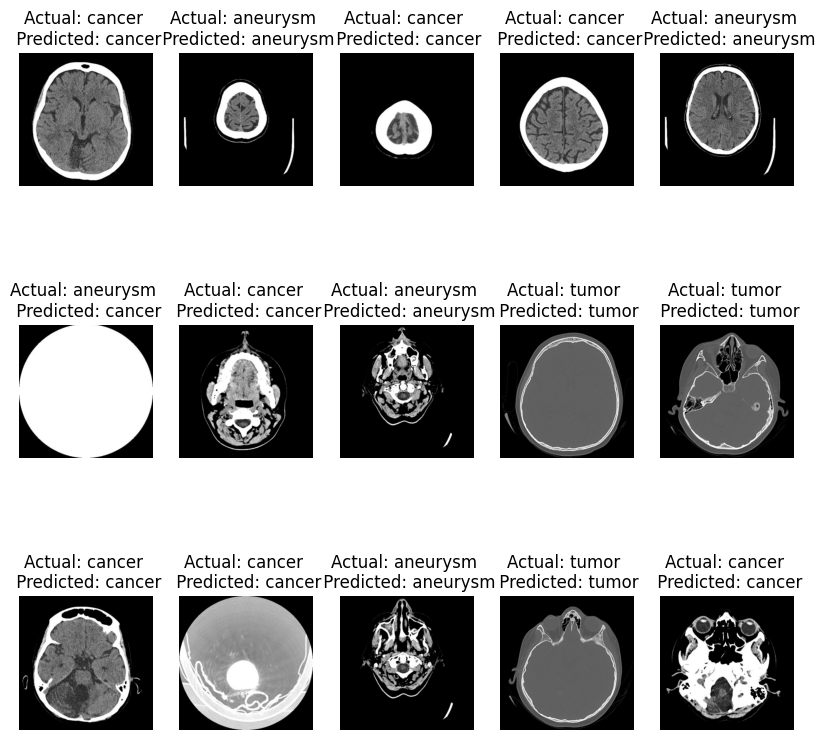

In [116]:
# predict showing the image and the label

for img, label in test_ds.take(1):
    plt.figure(figsize=(10,10))
    for i in range(15):
        plt.subplot(3,5,i+1)
        pred = model_2.predict(img.numpy())
        plt.title(f'Actual: {class_[label[i]]} \n Predicted: {class_[np.argmax(pred[i])]}')
        plt.imshow(img[i].numpy().astype('uint8'))
        plt.axis('off')


In [117]:
import torch

print(f'\nAvailable cuda = {torch.cuda.is_available()}')

print(f'\nGPUs availables = {torch.cuda.device_count()}')

print(f'\nCurrent device = {torch.cuda.current_device()}')

print(f'\nCurrent Device location = {torch.cuda.device(0)}')

print(f'\nName of the device = {torch.cuda.get_device_name(0)}')


Available cuda = True

GPUs availables = 1

Current device = 0

Current Device location = <torch.cuda.device object at 0x7fc16ea09c90>

Name of the device = NVIDIA GeForce RTX 4060 Laptop GPU


In [118]:
tf.sysconfig.get_build_info()

OrderedDict([('cpu_compiler', '/usr/lib/llvm-16/bin/clang'),
             ('cuda_compute_capabilities',
              ['sm_35', 'sm_50', 'sm_60', 'sm_70', 'sm_75', 'compute_80']),
             ('cuda_version', '11.8'),
             ('cudnn_version', '8'),
             ('is_cuda_build', True),
             ('is_rocm_build', False),
             ('is_tensorrt_build', True)])